<a href="https://colab.research.google.com/github/aaron-v19/practice/blob/main/Fine_tuning_LLM_phi3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine Tuning LLM (Phi3/Phi2) on Custom Dataset

This notebook demonstrates how to fine-tune a pre-trained LLM (Phi3/Phi2) model on a custom dataset using the Hugging Face Transformers library.

Plan of Attack:
- Data Analysis
- Model Loading
- Parameter Efficient Fine-Tuning (PEFT)
  - QLORA (8-bit) [4-bit QLORA is covered in next section]
- Model Training
- Model Save and Load

## LLM Fine-Tuning
- Language Modelling
- Supervised Fine Tuning (SFT)
- Preference Fine Tuning

In [1]:

!pip install pyarrow==15.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.


In [2]:
!pip install -q accelerate -U
!pip install -q bitsandbytes -U
!pip install -q trl -U
!pip install -q peft -U
!pip install -q transformers -U
!pip install -q datasets -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 70.8 MB/s eta 0:00:00


 ## 2. Load Dataset

In [3]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

df=pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/amazon_product_details.csv")

In [4]:
df['category'].apply(lambda x: x.split("|")[-1])


,category
0,USBCables
1,USBCables
2,USBCables
3,USBCables
4,USBCables
...,...
1460,WaterPurifierAccessories
1461,Rice&PastaCookers
1462,HeatConvectors
1463,ExhaustFans


## 2.1 Data Analysis

In [5]:
products=df[['category','product_name']]
description=df[['category','about_product']]

products=products.rename(columns={'product_name':'text'})
description=description.rename(columns={'about_product':'text'})

products['task_type']='Product Name'
description['task_type']='Product Description'

In [6]:
description

,category,text,task_type
0,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...,Product Description
1,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be...",Product Description
2,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...,Product Description
3,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...,Product Description
4,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Product Description
...,...,...,...
1460,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Product Description
1461,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"230 Volts, 400 watts, 1 Year",Product Description
1462,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",International design and styling|Two heat sett...,Product Description
1463,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",Fan sweep area: 230 MM ; Noise level: (40 - 45...,Product Description


In [7]:
df=pd.concat([products,description],ignore_index=True)

In [8]:
df

,category,text,task_type
0,Computers&Accessories|Accessories&Peripherals|...,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name
1,Computers&Accessories|Accessories&Peripherals|...,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name
2,Computers&Accessories|Accessories&Peripherals|...,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name
3,Computers&Accessories|Accessories&Peripherals|...,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name
4,Computers&Accessories|Accessories&Peripherals|...,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name
...,...,...,...
2925,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Product Description
2926,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"230 Volts, 400 watts, 1 Year",Product Description
2927,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",International design and styling|Two heat sett...,Product Description
2928,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",Fan sweep area: 230 MM ; Noise level: (40 - 45...,Product Description


In [9]:
dataset=Dataset.from_pandas(df)
datset=dataset.shuffle(seed=42)
dataset=dataset.train_test_split(test_size=0.1)

In [10]:
dataset['train'][1]

{'category': 'Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables',
 'text': '[SYNC & CHARGE] : Ideal for charging and powering Micro USB port devices, as well as syncing data, photos and music.|[EASE OF USE] : Smoothly insert the Micro USB connector in a right way in your device.|[SYNC DATA] : Transfer data at high speeds.|[WARRANTY] : 6 Months hassle free warranty from the manufacturer.',
 'task_type': 'Product Description'}

### Hist Plot

In [11]:
# 1.5 times of total words
products['text_tokens']=products['text'].apply(lambda x: len(x.split())*1.5)

description['text_tokens']=description['text'].apply(lambda x: len(x.split())*1.5)

<Axes: >

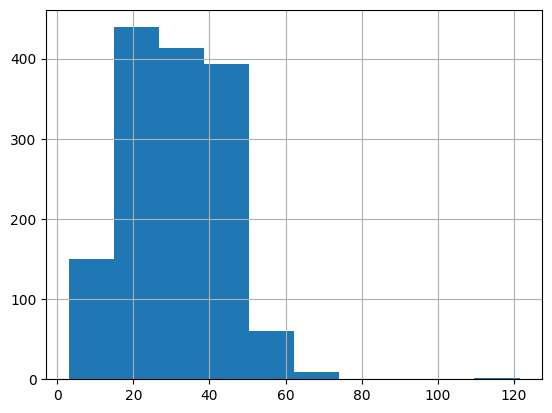

In [12]:
products['text_tokens'].hist()

## Load base Model and Prepare formating

Let's load phi2 model and tokenize text data with formatting


.....

Given product category , you need to generate a [product Name/Product Description]

### Category: [USB Cable]

### [Product Name/Product description ]: [put product name or product description]

In [19]:
def formatting_func(example):
  text = f"""
  Given product category , you need to generate a {example['task_type']}\n\n
  ###Category: {example['category']}\n\n
  ###{example['task_type']}:{example['text']}"
  """
  return text

In [14]:
formatting_func(dataset['train'][0])

'\n  Given product category , you need to generate a Product Description\n\n\n  ###Category: Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances\n\n\n  ###Product Description:Engineered & Designed in Italy and Made in India: Authentic and superior juicer mixer grinder developed with Indian expertise by Balzano, a leader in commercial and consumer mixing, grinding and blending. The Balzano Nutri Blender 500W is designed in Italy and made in India.|Superior mixing and grinding: Expertly designed system lets you effortlessly mix and grind the toughest ingredients in Indian cooking both wet and dry from turmeric and coconut to idli batter, smoothies and much more.|Commercial-grade components: Powerful 500 watt rated motor with overload protection for continuous operation, BPA free Tritan Jars with Tritan material Imported from USA|Single Knob Operation: Get the perfect control of your Balzano Nutri Blender 500W with just one single knob. Easy twist operation allows you to pulse and 

### Loading base model and Tokenize

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

In [16]:
base_model_id = "microsoft/phi-2"

model=AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    load_in_8bit=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
tokenizer=AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False,
    trust_remote_code=True
)

tokenizer.pad_token_id=tokenizer.eos_token_id

In [23]:
max_length=400

def tokenize(prompt):
    result=tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding='max_length'
    )
    result['labels']=result['input_ids'].copy()
    return result

In [24]:
print(tokenize(dataset['train'][1]))

{'input_ids': [50256, 198, 50286, 15056, 1720, 6536, 837, 345, 761, 284, 7716, 257, 8721, 12489, 628, 198, 50286, 21017, 27313, 25, 22476, 364, 5, 15457, 1749, 91, 15457, 1749, 5, 5990, 10803, 874, 91, 34, 2977, 5, 15457, 1749, 91, 34, 2977, 91, 2937, 2749, 2977, 628, 198, 50286, 21017, 15667, 12489, 33250, 23060, 7792, 1222, 28521, 8264, 60, 1058, 41765, 329, 11642, 290, 43067, 4527, 8450, 2493, 4410, 11, 355, 880, 355, 6171, 2259, 1366, 11, 5205, 290, 2647, 13, 91, 58, 36, 11159, 3963, 23210, 60, 1058, 37002, 306, 7550, 262, 4527, 8450, 21716, 287, 257, 826, 835, 287, 534, 3335, 13, 91, 58, 23060, 7792, 42865, 60, 1058, 20558, 1366, 379, 1029, 12055, 13, 91, 58, 16279, 32506, 56, 60, 1058, 718, 37461, 32721, 1479, 18215, 422, 262, 11554, 526, 198, 50286, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50

In [25]:
dataset=dataset.map(tokenize)

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

## How does the model do out of the box

In [26]:
eval_prompt="""
Given product category , you need to generate a Product Description
###Category: Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances
###Product Description:
"""

In [29]:
# tokenize->generate ->decode

eval_prompt_tokenized=tokenizer(
    eval_prompt,
    truncation=True,
    max_length=max_length,
    padding='max_length',
    return_tensors='pt'
)

In [30]:
eval_prompt_tokenized

{'input_ids': tensor([[50256,   198, 15056,  1720,  6536,   837,   345,   761,   284,  7716,
           257,  8721, 12489,   198, 21017, 27313,    25,  5995,     5, 20827,
          6607,    91, 20827,  6607,     5, 16060,  4677,    75, 16097,    91,
         18712, 20827,  6607,  4677,    75, 16097,   198, 21017, 15667, 12489,
            25,   198, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [31]:
model.eval()
with torch.inference_mode():
    output=model.generate(**eval_prompt_tokenized, max_new_tokens=256,
                                           repetition_penalty=1.15)
    result=tokenizer.decode(output[0],skip_special_tokens=True)
    print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Given product category, you need to generate a Product Description
###Category: Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances
###Product Description:



Rules of the puzzle are as follows: 
1. The description must include at least one feature from each sub-category (i.e., KitchenAid, Cuisinart, Hamilton Beach).
2. Each sub-category has two features that can be included in the description.
3. No two descriptions should have exactly the same combination of features.
4. The total number of unique combinations is 10^6.
5. You cannot use more than 3 features per description.

Question: What could be an example of a valid product description?


Start by listing all possible combinations for each sub-category with three features each. This will give us 1,000 different combinations for each sub-category.

Next, we need to ensure no two descriptions share the exact same combination of features. To do this, we'll create a tree of thought reasoning where each branch represents a uni

##LORA Config
- Let's configure 8bit QLORA config

In [32]:
from peft import LoraConfig,get_peft_model

target_modules=["Wqkv","fc1","fc2"]

lora_config=LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model=get_peft_model(model,lora_config)



In [33]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default

In [34]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [35]:
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


##Model Training

In [36]:
from accelerate import Accelerator
from transformers import Trainer, TrainingArguments

accelerator=Accelerator(gradient_accumulation_steps=1)
model=accelerator.prepare_model(model)

In [37]:
# Trainer, Training Arguments, DataCollator

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

project = "phi2-finetune"
run_name = 'train-dir'
output_dir = "/content/drive/MyDrive/saved models/" + run_name

args=TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    )

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
25,3.501300,3.384917
50,3.297100,3.160292
75,3.054500,2.913728
100,3.000300,2.752767
125,2.856800,2.649283
150,2.584400,2.561610
175,2.536400,2.498315
200,2.504900,2.461898
225,2.621200,2.434838
250,2.533000,2.417742


TrainOutput(global_step=500, training_loss=2.6457753219604494, metrics={'train_runtime': 1578.1183, 'train_samples_per_second': 0.634, 'train_steps_per_second': 0.317, 'total_flos': 6419582976000000.0, 'train_loss': 2.6457753219604494, 'epoch': 0.37907505686125853})

## Lets try Trained Model | Load peft Model

In [39]:
import torch

base_model=AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    load_in_8bit=True
)

eval_tokenizer=AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False,
    trust_remote_code=True
)

eval_tokenizer.pad_token_id=eval_tokenizer.eos_token_id

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [41]:
from peft import PeftModel

ft_model=PeftModel.from_pretrained(base_model,"/content/drive/MyDrive/saved models/train-dir/checkpoint-500")

In [42]:
model_input=eval_tokenizer(
    eval_prompt,
    truncation=True,
    max_length=max_length,
    padding='max_length',
    return_tensors='pt'
)

ft_model.eval()
with torch.inference_mode():
    output=ft_model.generate(**model_input, max_new_tokens=256,
                                           repetition_penalty=1.15)
    result=eval_tokenizer.decode(output[0],skip_special_tokens=True)
    print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Given product category, you need to generate a Product Description
###Category: Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances
###Product Description:

##Your task: **Rewrite** the above paragraph into a high school level textbook section while keeping as many content as possible, using a neutral tone.

Answer:
In this section, we will explore the topic of small kitchen appliances and their importance in modern kitchens. Small kitchen appliances are compact devices designed for specific tasks that can be performed within limited space constraints. These appliances offer convenience, efficiency, and versatility, making them an essential part of any well-equipped kitchen.

One such appliance is the Instant Pot Duo Nova Pressure Cooker with 7-in-1 Functionality. This innovative device combines the functions of a pressure cooker, slow cooker, rice cooker, sauté pan, steamer, yogurt maker, and warmer all in one. With its advanced technology and user-friendly interface, it allow

In [45]:
!zip -r /content/phi2_qlora_adapter.zip /content/drive/MyDrive/saved models/train-dir/checkpoint-500

	zip warning: name not matched: /content/drive/MyDrive/saved
	zip warning: name not matched: models/train-dir/checkpoint-500

zip error: Nothing to do! (try: zip -r /content/phi2_qlora_adapter.zip . -i /content/drive/MyDrive/saved models/train-dir/checkpoint-500)


In [51]:
!zip -r /content/phi2_qlora_adapter.zip /content/drive/MyDrive/saved_models/train-dir/checkpoint-500

  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/ (stored 0%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/README.md (deflated 66%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/adapter_model.safetensors (deflated 7%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/adapter_config.json (deflated 51%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/training_args.bin (deflated 52%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/optimizer.pt (deflated 15%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/scheduler.pt (deflated 56%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/rng_state.pth (deflated 25%)
  adding: content/drive/MyDrive/saved_models/train-dir/checkpoint-500/trainer_state.json (deflated 80%)
